In [1]:
import warnings 
import itertools

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy import stats
import seaborn as sns
import xarray as xr 

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
region_name_dicts = {5: 'Eastern U.S.', 17: 'West-Central Europe', 58: 'North East Asia'}
simulation_name_dicts = {'ref': 'Historical', 'refshort': 'High-warming', 'pol3.7short': 'Low-warming'}

In [3]:
ref_ds_emis = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_ref_c48.Emissions.april-august.nc4")
refshort_ds_emis = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_refshort_c48.Emissions.april-august.nc4")
polshort_ds_emis = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_polshort_c48.Emissions.april-august.nc4")

data_arrays_emis = [ref_ds_emis, refshort_ds_emis, polshort_ds_emis]

ref_ds_spec = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_ref_c48.SpeciesConc.april-august.nc4")
refshort_ds_spec = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_refshort_c48.SpeciesConc.april-august.nc4")
polshort_ds_spec = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_polshort_c48.SpeciesConc.april-august.nc4")

data_arrays_spec = [ref_ds_spec, refshort_ds_spec, polshort_ds_spec]

In [4]:
# Count total number of days between April and August
import pandas as pd
time_index = pd.to_datetime(ref_ds_emis.time.values)
april_aug_mask = (time_index.month >= 1) & (time_index.month <= 12)
total_days = april_aug_mask.sum()
print(f"Total days between Jan 1 and Dec 31: {total_days}")

Total days between Jan 1 and Dec 31: 2448


In [5]:
def get_regional_data(ds, my_variable, my_simulation, months, scale_factor):
    da = ds[my_variable]
    da = tools.mask_ocean_c48(da)
    da = da.sel(time=da.time.dt.month.isin(months))
    da = da.resample(time='1Y').mean() * scale_factor
    da = da.stack(new_dim=['sim', 'time'])
    da['name'] = simulation_name_dicts[my_simulation]

    #EUS: 
    region_num = 5
    da_EUS = tools.crop_regionmask_ar6_c48(da, region_num)
    da_EUS = da_EUS.mean(dim=['nf', 'Ydim', 'Xdim'])
    da_EUS['region_name'] = region_name_dicts[region_num]

    #WCE: 
    region_num = 17
    da_WCE = tools.crop_regionmask_ar6_c48(da, region_num)
    da_WCE = da_WCE.mean(dim=['nf', 'Ydim', 'Xdim'])
    da_WCE['region_name'] = region_name_dicts[region_num]

    #EAS: 
    region_num = 58
    da_EAS = tools.crop_regionmask_ar6_c48(da, region_num)
    da_EAS = da_EAS.mean(dim=['nf', 'Ydim', 'Xdim'])
    da_EAS['region_name'] = region_name_dicts[region_num]

    da_all = xr.concat([da_EUS, da_WCE, da_EAS],dim='concat_dim')
    return da_all

In [6]:
def get_dataframe(my_variable, data_arrays, months, scale_factor):

    if my_variable == "SpeciesConc_HOx":
        ref_HO2 = get_regional_data(data_arrays[0], "SpeciesConc_HO2", "ref", months, scale_factor)
        ref_OH = get_regional_data(data_arrays[0], "SpeciesConc_OH", "ref", months, scale_factor)
        ref = (ref_HO2+ref_OH)

        refshort_HO2 = get_regional_data(data_arrays[1], "SpeciesConc_HO2", "refshort", months, scale_factor)
        refshort_OH = get_regional_data(data_arrays[1], "SpeciesConc_OH", "refshort", months, scale_factor)
        refshort = (refshort_HO2+refshort_OH)

        polshort_HO2 = get_regional_data(data_arrays[2], "SpeciesConc_HO2", "pol3.7short", months, scale_factor)
        polshort_OH = get_regional_data(data_arrays[2], "SpeciesConc_OH", "pol3.7short", months, scale_factor)
        polshort = (polshort_HO2+polshort_OH)

        df = xr.concat([ref, polshort, refshort],dim='concat_dim').to_dataframe(name="SpeciesConc_HOx")
    else:    
        ref = get_regional_data(data_arrays[0], my_variable, "ref", months, scale_factor)
        refshort = get_regional_data(data_arrays[1], my_variable, "refshort", months, scale_factor)
        polshort = get_regional_data(data_arrays[2], my_variable, "pol3.7short", months, scale_factor)
        df = xr.concat([ref, polshort, refshort],dim='concat_dim').to_dataframe()
    return df 

In [7]:
months = [4,5,6,7,8]
# kgNO/m2/s to gN/m2/year 
# 1000g/kg * (14/30) kgN/kgNO * 86400 s/day * 365.25 days/year
scale_factor = 1000 * (14/30) * 86400 * (365.25)
EmisNO_Soil_df = get_dataframe("EmisNO_Soil", data_arrays_emis, months, scale_factor)

# kgNO/m2/s to gC/m2/year 
# 1000g/kg * (60.06/68.12) kgC/kgISOP * 86400 s/day * 365.25 days/year
scale_factor = 1000 * (60.06/68.12)  * 86400 * (365.25)

EmisISOP_Biogenic_df = get_dataframe("EmisISOP_Biogenic", data_arrays_emis, months, scale_factor)

scale_factor = 1e9  # ppbv
SpeciesConc_PAN_df = get_dataframe("SpeciesConc_PAN", data_arrays_spec, months, scale_factor)

scale_factor = 1e12 # pptv
SpeciesConc_HOx_df = get_dataframe("SpeciesConc_HOx", data_arrays_spec, months, scale_factor)

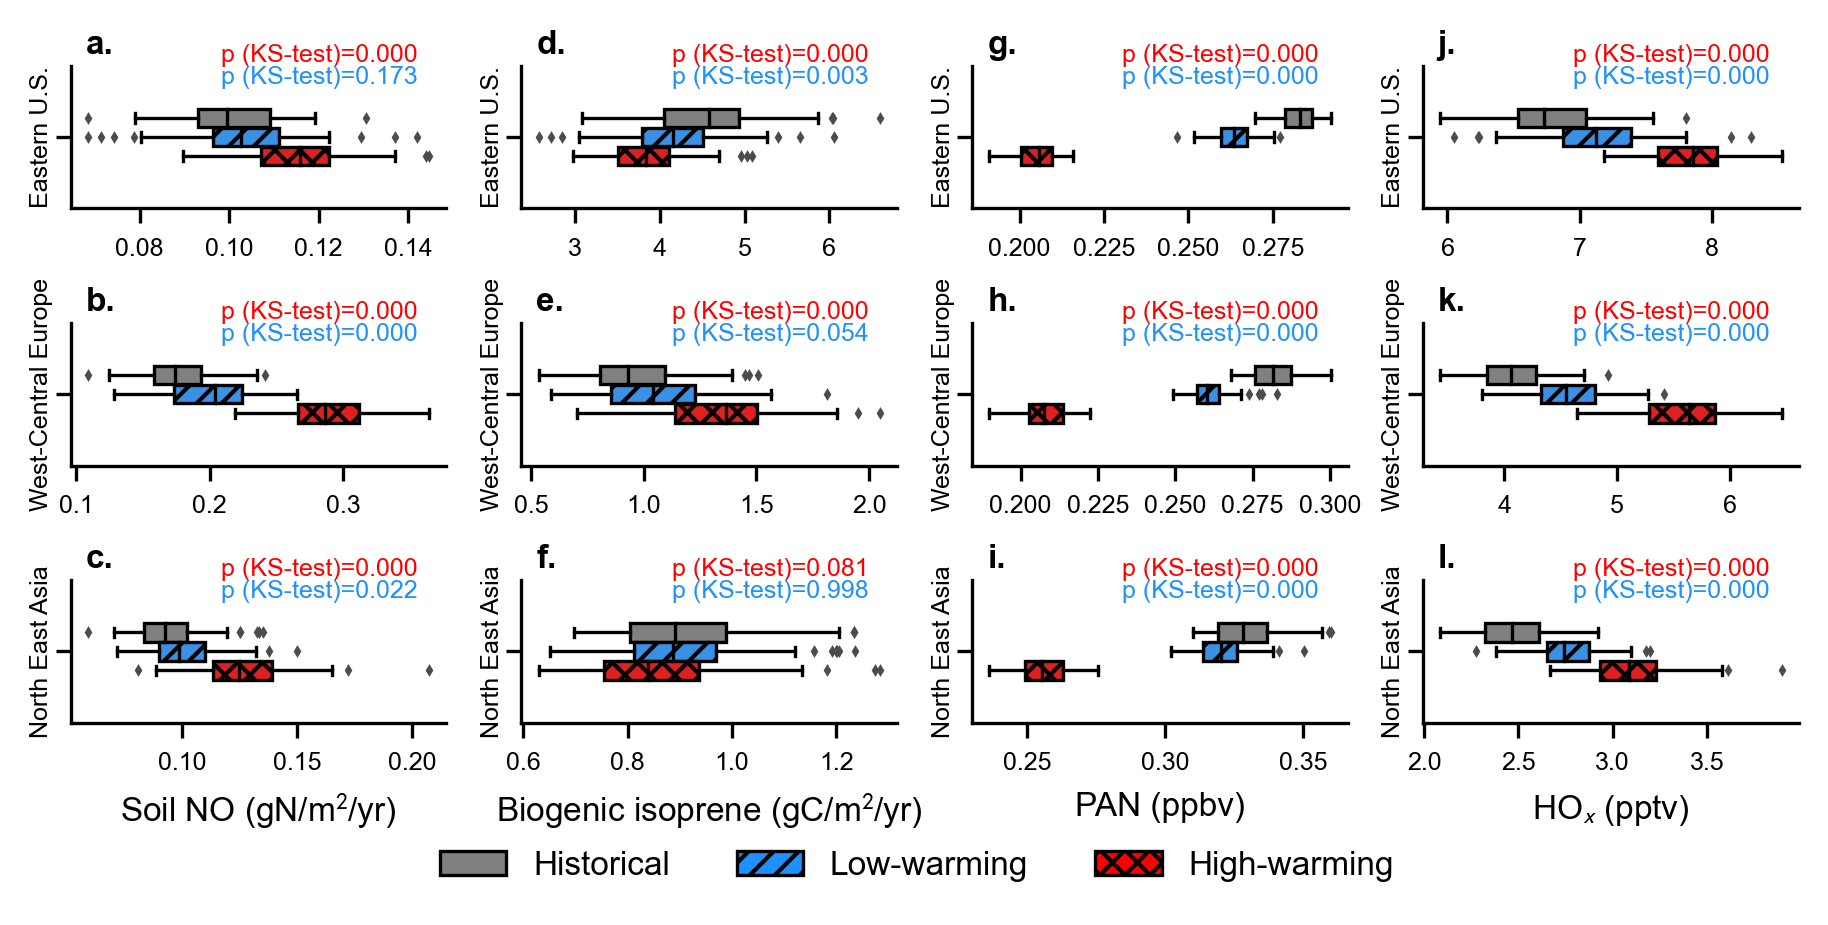

In [8]:
tools.set_matplotlib_font("Arial")
fig = plt.figure(figsize=(6, 3.0), dpi=300)

outer_gs = gridspec.GridSpec(
    1, 4, figure=fig,
    top=0.95, bottom=0.22, left=0.03, right=0.99,
    wspace=0.2, hspace=0.05
)
dfs = [EmisNO_Soil_df, EmisISOP_Biogenic_df, SpeciesConc_PAN_df, SpeciesConc_HOx_df]
PROPS = {
    'boxprops': {'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k'}
}
my_variables = ['EmisNO_Soil', 'EmisISOP_Biogenic', 'SpeciesConc_PAN', 'SpeciesConc_HOx']
xlabels = [
    r"Soil NO (gN/m$^2$/yr)",
    r"Biogenic isoprene (gC/m$^2$/yr)",
    r"PAN (ppbv)",
    r"HO$_x$ (pptv)",
]
colors = ["grey", "dodgerblue", "red"]
regions = ['Eastern U.S.', 'West-Central Europe', 'North East Asia']
titles = ["a.", "b.", "c.", "d.", "e.", "f.", "g.", "h.", "i.", "j.", "k.", "l."]

for outer_ind in range(4):
    
    row = outer_ind // 2
    col = outer_ind % 2

    inner_gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer_gs[0, outer_ind], hspace=0.8)
    
    df = dfs[outer_ind]
    variable = my_variables[outer_ind]
    xlabel = xlabels[outer_ind]

    # Loop over inner GridSpec rows to create each subplot
    for inner_ind in range(3):

        global_idx = outer_ind * 3 + inner_ind

        ax = fig.add_subplot(inner_gs[inner_ind, 0])
        region = regions[inner_ind]
        data = df[df.region_name == region]

        a = sns.boxplot(
            x=variable, y="region_name", ax=ax,
            hue="name", palette=colors, width=0.4, whis=1.2, linewidth=0.8, fliersize=0.8,
            data=data, **PROPS
        )

        hatches = ['////', '', 'xxxx', '////', '', 'xxxx']
        for i, bar in enumerate(a.patches):
            if i < len(hatches):
                bar.set_hatch(hatches[i])

        p_pd = data[data.name == 'Historical'].dropna()
        f_pd = data[data.name == 'High-warming'].dropna()
        fp_pd = data[data.name == 'Low-warming'].dropna()

        _, f_pval_ks = stats.ks_2samp(p_pd[variable], f_pd[variable])
        _, fp_pval_ks = stats.ks_2samp(p_pd[variable], fp_pd[variable])

        formatted_f_pval_ks = format(f_pval_ks, ".3f")
        formatted_fp_pval_ks = format(fp_pval_ks, ".3f")

        ax.text(0.04, 1.25, titles[global_idx],
                ha='left', va='top', transform=ax.transAxes, color='black', fontsize=8, weight='bold')
        ax.text(0.4, 1.15, "p (KS-test)=" + formatted_f_pval_ks,
                ha='left', va='top', transform=ax.transAxes, color='red', fontsize=6)
        ax.text(0.4, 1.0, "p (KS-test)=" + formatted_fp_pval_ks,
                ha='left', va='top', transform=ax.transAxes, color='dodgerblue', fontsize=6)

        ax.set_ylabel(None)
        ax.set_yticks(ax.get_yticks())
        if global_idx != 0:
            ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center', va='center', fontsize=6)
        else:
            ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center', va='center', fontsize=8)
        ax.spines[['right', 'top']].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.legend([], [], frameon=False)
        
        # Set xlabel only for the bottom subplot in each column
        if inner_ind == 2:
            ax.set_xlabel(xlabel, fontsize=8)
        else:
            ax.set_xlabel("")
 
categories = ["Historical", "Low-warming", "High-warming"]
colors = ["grey", "dodgerblue", "red"]
hatches = ["", "////", "xxxx"] 

legend_patches = []
for cat, color, hatch in zip(categories, colors, hatches):
    patch = patches.Patch(
        facecolor=color, 
        hatch=hatch,
        edgecolor="k", 
        linewidth=0.8,
        label=cat
    )
    legend_patches.append(patch)

fig.legend(
    handles=legend_patches,
    loc="lower center",
    ncol=len(categories),
    bbox_to_anchor=(0.5, 0.01),
    frameon=False,
    fontsize=8
)

################
plt.savefig("Fig4_new.pdf")